# Mask R-CNN

- 객체 탐지 모델으로부터 시작

  - 예측된 경계 상자가 정확하면 분할 네트워크가 할 일은 단순

  - 해당 패치에서 어느 픽셀이 캡처된 클래스에 속하는지, 어느 픽셀이 배경의 일부이고 어느 픽셀이 다른 클래스에 속하는지 분류

- 사전 훈련된 탐지 네트워크와 뒤에 사전 훈련된 분할 네트워크를 하나로 이어서 End-to-End 방식으로 훈련하여 전체 파이프라인의 성능이 좋아짐을 보임

- Facebook AI Research(FAIR)

- 주로 Faster R-CNN에 기반

  - 참고
    - https://curt-park.github.io/2017-03-17/faster-rcnn/

    - https://tensorflow.blog/2017/06/05/from-r-cnn-to-mask-r-cnn/
- 3번째 병렬 분기를 추가해 확장함으로써 각 영역의 요소에 대한 이진 마스크 출력

  - 해당 분류기를 통해 분류와 분할을 분리할 수 있음

  - 분할 분기는 N개의 이진 마스크(다른 일반적인 의미론적 분할 모델처럼 클래스당 한 개)를 출력하도록 정의되지만,  
    다른 분기에 의해 예측된 클래스에 대응하는 마스크만 최종 예측과 훈련 손실을 계산할 때 사용됨

  <img src="https://miro.medium.com/max/6060/1*M_ZhHp8OXzWxEsfWu2e5EA.png">

  <sub>[이미지 출처] https://medium.com/@jonathan_hui/image-segmentation-with-mask-r-cnn-ebe6d793272</sub>



## Mask R-CNN Implement

- [런타임 유형] - GPU 설정

- 코드 참고
  - https://www.tensorflow.org/tutorials/images/segmentation
  - https://github.com/tensorflow/examples.git

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

from torchvision import transforms, datasets
import torchvision.transforms.functional as TF

import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-white')

torch.cuda.empty_cache()

### Oxford-IIIT Pets 데이터 세트를 다운로드

- Parkhi *et al*이 만든 [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) 데이터 세트는 영상, 해당 레이블과 픽셀 단위의 마스크로 구성
- 마스크는 기본적으로 각 픽셀의 레이블
- 각 픽셀은 다음 세 가지 범주 중 하나

  *   class 1 : 애완동물이 속한 픽셀
  *   class 2 : 애완동물과 인접한 픽셀
  *   class 3 : 위에 속하지 않는 경우/주변 픽셀

In [2]:
class OxfordPetsData(Dataset):
    def __init__(self, img_dir, label_dir, img_transform=None, label_transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.img_transform = img_transform
        self.label_transform = label_transform
        self.imgs = [img for img in os.listdir(img_dir) if img.endswith('.jpg')]

    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        img_name = self.imgs[idx]
        img_path = os.path.join(self.img_dir, img_name)
        label_path = os.path.join(self.label_dir, img_name.replace("jpg", "png"))
        
        img = Image.open(img_path).convert('RGB')
        label = Image.open(label_path)
        
        if self.img_transform:
            img = self.img_transform(img)
            
        if self.label_transform:
            label = self.label_transform(label)
            
        return img, label

def cvt_label(x):
    return torch.from_numpy(np.array(x, dtype=np.int32)) - 1

img_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])
label_transform = transforms.Compose([
    transforms.Resize((128, 128), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.Lambda(cvt_label)
])

BATCH_SIZE = 128
BASE_PATH = os.path.join(os.getcwd(), 'data')

dataset = OxfordPetsData(img_dir=os.path.join(BASE_PATH, 'images'), label_dir=os.path.join(BASE_PATH, 'annotations', 'trimaps'), img_transform=img_transform, label_transform=label_transform)
train_size = int(len(dataset) * .8)
train_dataset, test_dataset = random_split(dataset, (train_size, len(dataset) - train_size))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, pin_memory=True)

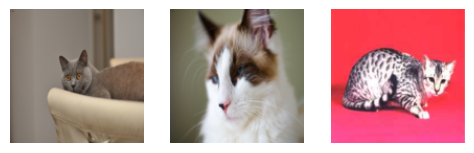

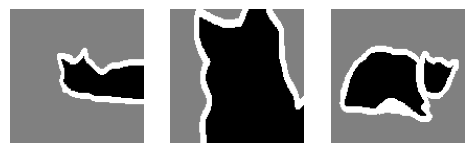

In [3]:
def show_images_and_labels(loader):
    images, labels = next(iter(loader))
    
    plt.figure(figsize=(10, 5))
    for i, img in enumerate(images[:3]):
        plt.subplot(2, 5, i+1)
        plt.imshow(img.permute(1, 2, 0))
        plt.axis('off')
    
    plt.figure(figsize=(10, 5))
    for i, lbl in enumerate(labels[:3]):
        plt.subplot(2, 5, i+6)
        plt.imshow(lbl.squeeze(), cmap='gray')
        plt.axis('off')
    plt.show()

show_images_and_labels(train_loader)

### 모델 정의

- 사용된 모델은 수정된 U-Net
- U-Net은 인코더(다운샘플러)와 디코더(업샘플러)를 포함
- 강력한 기능을 학습하고 훈련 가능한 매개변수의 수를 줄이기 위해 미리 훈련된 모델을 인코더로 사용할 수 있음  
- 인코더는 미리 훈련된 MobileNetV2 모델이 될 것이며 이 모델의 중간 출력이 사용
- 디코더는 Pix2pix 튜토리얼의 TensorFlow 예제에서 이미 구현된 업샘플 블록이 될 것
- 3개의 채널을 출력하는 이유는 픽셀당 3개의 가능한 라벨이 있기 때문
- 각 화소가 세 개의 class로 분류되는 다중 분류라고 생각

In [4]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.conv_block(x)

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.encoder_block = nn.Sequential(
            nn.MaxPool2d(2, 2),
            ConvBlock(in_channels, out_channels)
        )
        
    def forward(self, x):
        x = self.encoder_block(x)

        return x

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, 2, 2)
        self.conv = ConvBlock(in_channels, out_channels)
    
    def forward(self, x, skip):
        x = self.up(x)
        x = torch.cat((x, skip), dim=1)
        x = self.conv(x)
        
        return x


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super().__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
                                                        # [3, 128, 128]
        self.inp = ConvBlock(n_channels, 64)            # [64, 128, 128]
        
        self.e1 = EncoderBlock(64, 128)                 # [128, 64, 64]
        self.e2 = EncoderBlock(128, 256)                # [256, 32, 32]
        self.e3 = EncoderBlock(256, 512)                # [512, 16, 16]  
        
        self.d1 = DecoderBlock(512, 256)                # [256 + 256, 32, 32]
        self.d2 = DecoderBlock(256, 128)                # [128 + 128, 64, 64]
        self.d3 = DecoderBlock(128, 64)                 # [64 + 64, 128, 128]
        
        self.out = nn.Conv2d(64, n_classes, 1, 1)       # [3, 128, 128]

        self.apply(self.init_params)
        
    def forward(self, x):
        x1 = self.inp(x)
        x2 = self.e1(x1)
        x3 = self.e2(x2)
        x4 = self.e3(x3)
        
        x = self.d1(x4, x3)
        x = self.d2(x, x2)
        x = self.d3(x, x1)
        x = self.out(x)
        
        return x
    
    @staticmethod
    def init_params(m):
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
            if m.bias is not None:
                nn.init.zeros_(m.bias)


In [5]:
model = UNet(n_channels=3, n_classes=3).to('cuda')

### 모델 학습

In [6]:
epochs = 50
lr = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(), lr=lr)

In [7]:
def train(model: nn.Module, train_loader: DataLoader, criterion: nn.modules.loss._Loss, optimizer: optim.Optimizer, epochs: int):
    model.train()
    
    for epoch in range(epochs):
        running_loss = 0.
        correct = 0
        total = 0
        
        for idx, (inputs, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            inputs, labels = inputs.to('cuda'), labels.to('cuda').long()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            pred = torch.argmax(outputs.data, dim=1)
            correct += torch.eq(labels, pred).sum().item()
            total += labels.numel()
            
            print(f'Epoch: {epoch + 1}, Step: {idx + 1}/{len(train_loader)}, Loss: {running_loss / (idx + 1):.6f}, Accuracy: {correct / total * 100:.2f}%')

def test(model: nn.Module, test_loader: DataLoader, criterion: nn.modules.loss._Loss):
    model.eval()
    
    with torch.no_grad():
        t_loss = 0.
        correct = 0
        total = 0
        
        for inputs, labels in test_loader:
            inputs, labels = inputs.to('cuda'), labels.to('cuda').long()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            pred = torch.argmax(outputs.data, dim=1)
            
            t_loss += loss.item()
            correct += torch.eq(labels, pred).sum().item()
            total += labels.numel()
        
        t_loss /= len(test_loader)
        acc = correct / total # type: ignore
    
    print('Test')
    print(f'Loss: {t_loss:.6f}, Accuracy: {acc * 100:.2f}%')

In [8]:
train(model, train_loader, criterion, optimizer, epochs)

Epoch: 1, Step: 1/47, Loss: 1.760433, Accuracy: 22.85%
Epoch: 1, Step: 2/47, Loss: 1.771967, Accuracy: 22.23%
Epoch: 1, Step: 3/47, Loss: 1.751748, Accuracy: 22.69%
Epoch: 1, Step: 4/47, Loss: 1.735712, Accuracy: 23.12%
Epoch: 1, Step: 5/47, Loss: 1.722689, Accuracy: 23.38%
Epoch: 1, Step: 6/47, Loss: 1.708921, Accuracy: 23.62%
Epoch: 1, Step: 7/47, Loss: 1.695562, Accuracy: 23.93%
Epoch: 1, Step: 8/47, Loss: 1.678596, Accuracy: 24.30%
Epoch: 1, Step: 9/47, Loss: 1.661745, Accuracy: 24.73%
Epoch: 1, Step: 10/47, Loss: 1.649665, Accuracy: 25.05%
Epoch: 1, Step: 11/47, Loss: 1.638722, Accuracy: 25.28%
Epoch: 1, Step: 12/47, Loss: 1.623340, Accuracy: 25.69%
Epoch: 1, Step: 13/47, Loss: 1.608510, Accuracy: 26.09%
Epoch: 1, Step: 14/47, Loss: 1.592548, Accuracy: 26.54%
Epoch: 1, Step: 15/47, Loss: 1.576850, Accuracy: 27.03%
Epoch: 1, Step: 16/47, Loss: 1.564064, Accuracy: 27.44%
Epoch: 1, Step: 17/47, Loss: 1.546849, Accuracy: 28.06%
Epoch: 1, Step: 18/47, Loss: 1.531956, Accuracy: 28.68%
E

In [9]:
test(model, test_loader, criterion)

Test
Loss: 0.628038, Accuracy: 84.33%


### 학습된 모델을 활용하여 예측

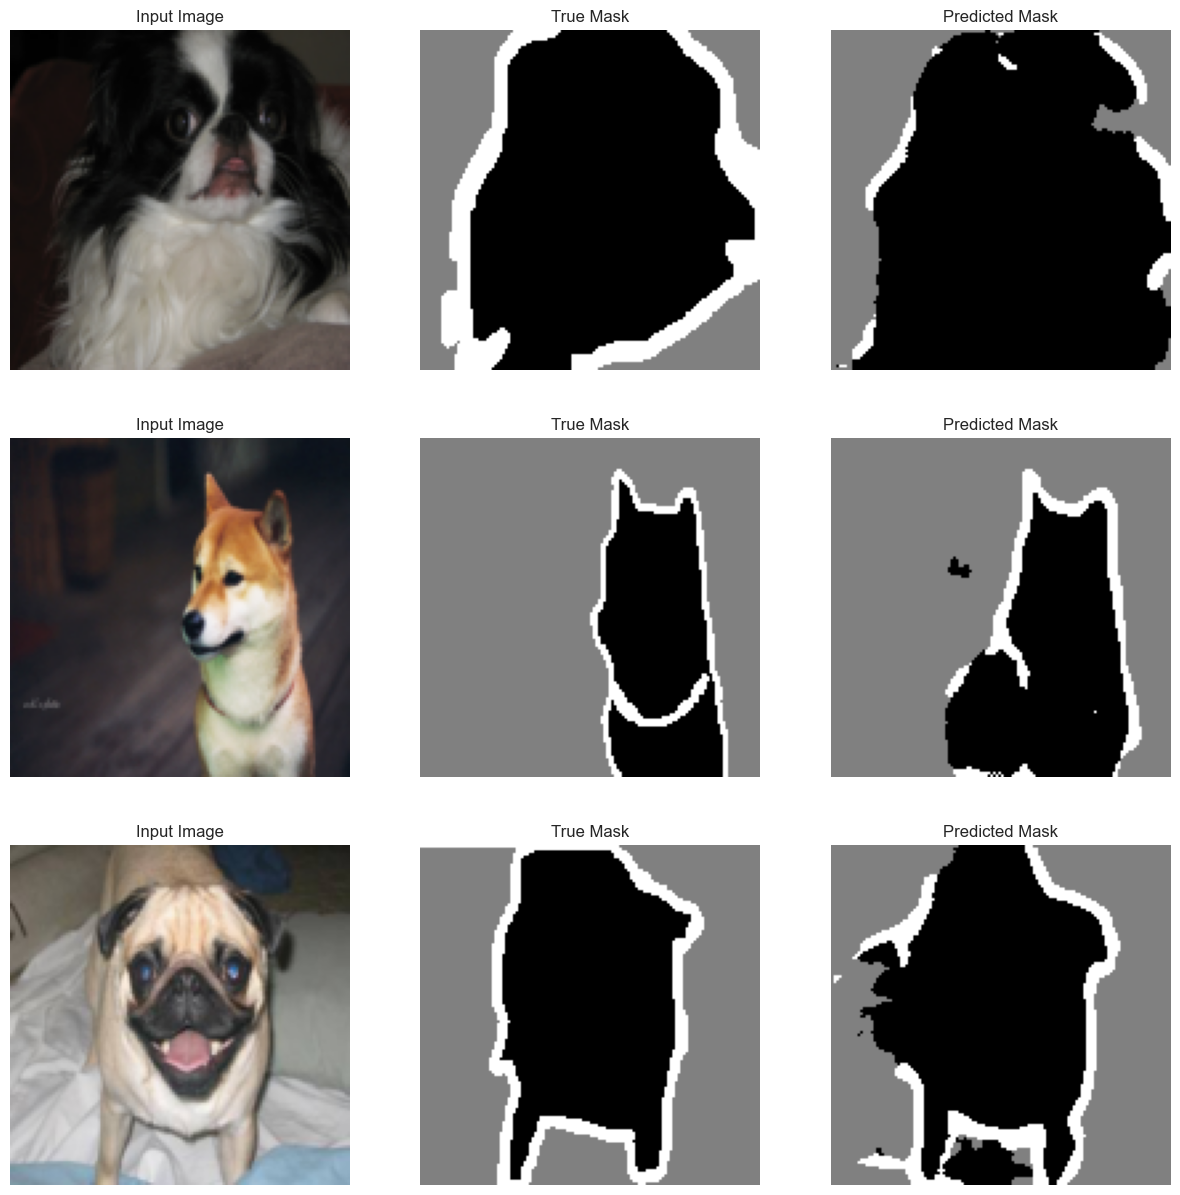

In [15]:
def visualize_predictions(model, loader, device='cuda', num_images=3):
    model.eval()
    
    images, labels = next(iter(loader))
    images, labels = images.to(device), labels.to(device)
    
    with torch.no_grad():
        predictions = model(images)
        
    predictions = torch.argmax(predictions, dim=1)

    plt.figure(figsize=(15, 5 * num_images))
    for idx in range(num_images):
        plt.subplot(num_images, 3, idx*3 + 1)
        plt.imshow(images[idx].cpu().permute(1, 2, 0))
        plt.title("Input Image")
        plt.axis('off')

        plt.subplot(num_images, 3, idx*3 + 2)
        plt.imshow(labels[idx].cpu(), cmap='gray')
        plt.title("True Mask")
        plt.axis('off')

        plt.subplot(num_images, 3, idx*3 + 3)
        plt.imshow(predictions[idx].cpu(), cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')

    plt.show()

visualize_predictions(model, test_loader, device='cuda', num_images=3)